In [1]:
import torch
from torchvision.models import resnet34
from torch import nn
from utils import load_model
from pathlib import Path
import os

# load the plantnet model
plantnet_model_path = Path("../models/plantnet_resnet34_best.tar")
plantnet_model = resnet34(num_classes=1081)

load_model(plantnet_model, filename=plantnet_model_path, use_gpu=True)


/home/kaka/repo/plants-toxic-for-cats/notebooks/utils.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(filename, map_location=device)


22

In [2]:
# setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
data_path = Path("../data/train_test")
train_path = data_path / "train"
test_path = data_path / "test"
new_species_names = [name for name in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, name))]
new_species_names = sorted(new_species_names)
print(new_species_names)

['African Violet', 'Aloe Vera plant', 'Anthurium (Anthurium andraeanum)', 'Areca Palm', 'Asparagus Fern (Asparagus setaceus)', 'Begonia (Begonia spp.)', 'Bird of Paradise (Strelitzia reginae)', "Bird's Nest Fern", 'Boston Fern', 'Bromeliad', 'Calathea', 'Cast Iron Plant', 'Chinese Money Plant', 'Chinese evergreen', 'Christmas Cactus', 'Croton', 'Ctenanthe', 'Dracaena', 'Dumb Cane (Dieffenbachia spp.)', 'Elephant Ear (Alocasia spp.)', 'English Ivy (Hedera helix)', 'Ficus Benjamina (Ficus benjamina)', 'Grape Ivy', 'Hoya', 'Iron Cross begonia', 'Jade plant', 'Kalanchoe', 'Lipstick Plant', 'Money Tree', 'Monstera Deliciosa (Monstera deliciosa)', 'Moth Orchid', 'Norfolk Island Pine', 'Orchid', 'Parlor Palm', 'Peace lily', 'Peperomia', 'Philodendron', 'Polka Dot Plant', 'Ponytail Palm', 'Pothos', 'Prayer Plant', 'Rattlesnake Plant', 'Rex Begonia', 'Rubber Plant', 'Schefflera', 'Snake plant', 'Spider Plant', 'String of Hearts Plant', 'Tradescantia', 'Umbrella Plant', 'Venus Flytrap', 'Yucca',

In [8]:
# freeze all the layers
for param in plantnet_model.parameters():
    param.requires_grad = False
    
# replace the final layer
num_features = plantnet_model.fc.in_features
# num_old_classes = 1081
num_new_classes = len(new_species_names)
#um_total_classes = num_old_classes + num_new_classes

#plantnet_model.fc = nn.Linear(num_features, num_total_classes)
plantnet_model.fc = nn.Linear(num_features, num_new_classes)
# initialize weights for new classes
# with torch.no_grad():
#     nn.init.zeros_(plantnet_model.fc.weight[num_old_classes:])
#     nn.init.zeros_(plantnet_model.fc.bias[num_old_classes:])


In [9]:
# define transformations
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# load the dataset
train_dataset = ImageFolder(train_path, transform=transform)
test_dataset = ImageFolder(test_path, transform=transform)

In [6]:
from torch.utils.data import Dataset

class OffsetLabelData(Dataset):
    def __init__(self, original_dataset, offset):
        self.original_dataset = original_dataset
        self.offset = offset
        
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, idx):
        image, label = self.original_dataset[idx]
        label += self.offset
        
        return image, label

In [7]:
# offset the dataset so we have new labels
#offset_train_dataset = OffsetLabelData(train_dataset, num_old_classes)
#offset_test_dataset = OffsetLabelData(test_dataset, num_old_classes)

In [10]:
from torch.utils.data import DataLoader
#train_loader = DataLoader(offset_train_dataset, batch_size=32, shuffle=True)
#test_loader = DataLoader(offset_test_dataset, batch_size=32, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

original_class_to_idx = train_dataset.class_to_idx
#new_class_to_idx = {class_name: idx + 1081 for class_name, idx in original_class_to_idx.items()}
#new_class_to_idx

In [10]:
# define the loss function
import torch.nn.functional as F

def custom_loss(outputs, targets):
    # only consider outputs for new classes
    new_class_outputs = outputs[:, 1081:]
    
    # adjust targets to start from 0 for new classes
    adjusted_targets = targets - 1081
    return F.cross_entropy(new_class_outputs, adjusted_targets)

criterion = custom_loss

In [11]:
criterion = nn.CrossEntropyLoss()

In [12]:
from tqdm import tqdm

def train_test_loop(model, train_loader, test_loader, custom_loss, device, num_epochs=10, learning_rate=0.001):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_batches = 0
        
        # Training loop
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            #loss = custom_loss(outputs, labels)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
            train_pbar.set_postfix({'loss': train_loss / train_batches})
        
        avg_train_loss = train_loss / train_batches
        train_losses.append(avg_train_loss)
        
        # Testing loop
        model.eval()
        test_loss = 0.0
        test_batches = 0
        
        with torch.inference_mode():
            test_pbar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Test]')
            for inputs, labels in test_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                #loss = custom_loss(outputs, labels)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                test_batches += 1
                test_pbar.set_postfix({'loss': test_loss / test_batches})
        
        avg_test_loss = test_loss / test_batches
        test_losses.append(avg_test_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}')
        print(f'  Test Loss: {avg_test_loss:.4f}')
    
    return train_losses, test_losses

In [13]:
# run the training and testing loop
num_epochs = 10
device = "cuda" if torch.cuda.is_available() else "cpu"
train_losses, test_losses = train_test_loop(plantnet_model, train_loader, test_loader, criterion, device, num_epochs)


Epoch 1/10 [Train]:   4%|▎         | 16/432 [00:28<10:01,  1.45s/it, loss=3.83]/home/kaka/anaconda3/envs/plants-toxic-for-cats/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/10 [Test]:  51%|█████▏    | 56/109 [01:48<01:35,  1.80s/it, loss=0.948]/home/kaka/anaconda3/envs/plants-toxic-for-cats/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
Epoch 1/10 [Test]: 100%|██████████| 109/109 [03:06<00:00,  1.71s/it, loss=1.03]


Epoch 1/10:
  Train Loss: 1.7003
  Test Loss: 1.0258


Epoch 2/10 [Test]: 100%|██████████| 109/109 [02:46<00:00,  1.52s/it, loss=0.897]


Epoch 2/10:
  Train Loss: 1.0341
  Test Loss: 0.8966


Epoch 3/10 [Test]: 100%|██████████| 109/109 [03:08<00:00,  1.73s/it, loss=0.851]


Epoch 3/10:
  Train Loss: 0.9206
  Test Loss: 0.8508


Epoch 4/10 [Test]: 100%|██████████| 109/109 [02:39<00:00,  1.46s/it, loss=0.843]


Epoch 4/10:
  Train Loss: 0.8626
  Test Loss: 0.8430


Epoch 5/10 [Test]: 100%|██████████| 109/109 [02:31<00:00,  1.39s/it, loss=0.824]


Epoch 5/10:
  Train Loss: 0.8193
  Test Loss: 0.8237


Epoch 6/10 [Test]: 100%|██████████| 109/109 [02:35<00:00,  1.43s/it, loss=0.82] 


Epoch 6/10:
  Train Loss: 0.7816
  Test Loss: 0.8197


Epoch 7/10 [Test]: 100%|██████████| 109/109 [02:31<00:00,  1.39s/it, loss=0.814]


Epoch 7/10:
  Train Loss: 0.7495
  Test Loss: 0.8141


Epoch 8/10 [Test]: 100%|██████████| 109/109 [02:29<00:00,  1.37s/it, loss=0.783]


Epoch 8/10:
  Train Loss: 0.7323
  Test Loss: 0.7835


Epoch 9/10 [Test]: 100%|██████████| 109/109 [02:30<00:00,  1.38s/it, loss=0.799]


Epoch 9/10:
  Train Loss: 0.7080
  Test Loss: 0.7994


Epoch 10/10 [Test]: 100%|██████████| 109/109 [02:29<00:00,  1.37s/it, loss=0.783]

Epoch 10/10:
  Train Loss: 0.6927
  Test Loss: 0.7830


In [15]:
# save the model
save_path = Path("../models/plantnet_finetuned_resnet34_v2.tar")
torch.save(plantnet_model.state_dict(), save_path)

In [16]:
import json

loss_data = {
    "train_losses": train_losses,
    "test_losses": test_losses
}

with open("../models/plantnet_finetuned_resnet34_v2_losses.json", "w") as f:
    json.dump(loss_data, f)
    

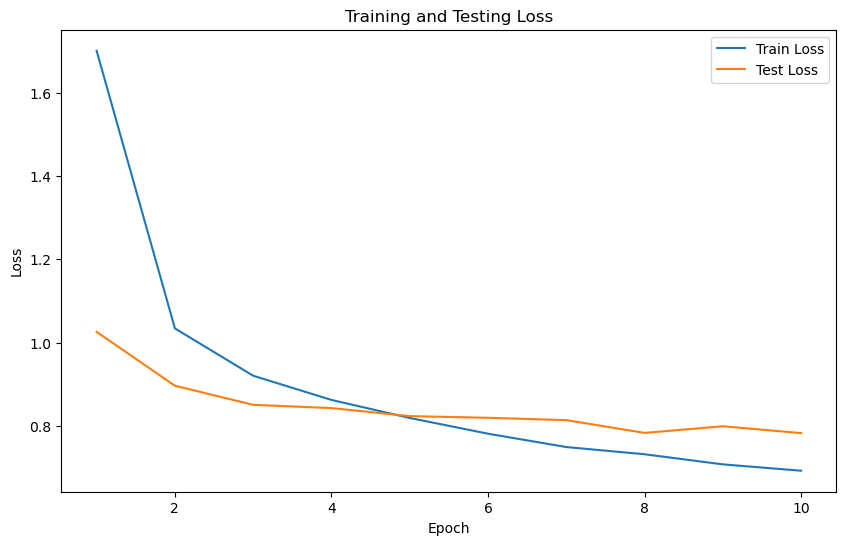

In [17]:
import matplotlib.pyplot as plt

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

In [18]:

import torch
from torchvision.transforms import v2
from PIL import Image
import os

def predict_image(model, image_path, device, class_names=None):
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Define the same transformations used during training
    transform = v2.Compose([
        v2.Resize(256),
        v2.CenterCrop(224),
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load and preprocess the image
    try:
        image = Image.open(image_path).convert('RGB')
    except:
        print(f"Error opening image file: {image_path}")
        return None
    
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        
    # Get the predicted class
    _, predicted_idx = torch.max(outputs, 1)
    
    # Convert to class name
    if class_names is None:
        predicted_class = predicted_idx.item()
    else:
        predicted_class = class_names[predicted_idx.item() - 1081]
    
    # Get the probability
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    confidence = probabilities[0][predicted_idx.item()].item()
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    
    return predicted_class, confidence, top5_prob, top5_catid

In [19]:
class_names = list(original_class_to_idx.keys())

In [33]:
img_path = Path("../data/7.webp")

predicted_class, confidence, top5_prob, top5_catid = predict_image(plantnet_model, img_path, device)

print("Predicted class:", class_names[predicted_class])
print(predicted_class, confidence, top5_prob, top5_catid)

Predicted class: Dracaena
17 0.5516626238822937 tensor([[0.5517, 0.1316, 0.0937, 0.0866, 0.0553]], device='cuda:0') tensor([[17, 38, 51, 33, 29]], device='cuda:0')


In [35]:
class_names[]

'Yucca'